In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir('/content/drive/MyDrive/Code + Data')
import tobit
from tobit import TobitModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report


# Load and Check Data

In [ ]:
final_train_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/stacked_model_predictions_train.parquet')
final_train_data.head()

,review_id,readability_pred,review_type_pred,business_type_pred,helpful,aspect_pred
4,--1m338Otp2qNcmUqM-ZDA,0.035773,0.269441,0.0,0.000000,0.0
6,--1znpBSRhz8qtYQ5me6EA,0.000000,0.105268,0.0,0.124844,0.0
8,--2GRMcnwPhFZjvMPH8caQ,0.000000,0.083722,0.0,0.000000,0.0
10,--2Xzl1U0aKxVL2LsYjTqA,0.005402,0.152865,0.0,0.000000,0.0
19,--3tvNOGHrt3aor2XkYmsw,0.000261,0.118061,0.0,0.089928,0.0


In [ ]:
# Check which columns contain NaN values
columns_with_nans = final_train_data.isna().any()

# Display columns with NaN values
print(columns_with_nans)

review_id             False
readability_pred      False
review_type_pred      False
business_type_pred    False
helpful               False
aspect_pred           False
dtype: bool


In [ ]:
final_test_data = pd.read_parquet('/content/drive/MyDrive/Code + Data/stacked_model_predictions_test.parquet')
final_test_data.head()

,review_id,readability_pred,review_type_pred,business_type_pred,helpful,aspect_pred
4,--1m338Otp2qNcmUqM-ZDA,0.035773,0.269441,0.0,0.000000,0.0
6,--1znpBSRhz8qtYQ5me6EA,0.000000,0.105268,0.0,0.124844,0.0
8,--2GRMcnwPhFZjvMPH8caQ,0.000000,0.083722,0.0,0.000000,0.0
10,--2Xzl1U0aKxVL2LsYjTqA,0.005402,0.152865,0.0,0.000000,0.0
19,--3tvNOGHrt3aor2XkYmsw,0.000261,0.118061,0.0,0.089928,0.0


In [ ]:
# Check which columns contain NaN values
columns_with_nans = final_test_data.isna().any()

# Display columns with NaN values
print(columns_with_nans)

review_id             False
readability_pred      False
review_type_pred      False
business_type_pred    False
helpful               False
aspect_pred           False
dtype: bool


# Training

In [ ]:
# TRAIN
train_df = final_train_data.copy()

train_df['readability_pred'] = train_df['readability_pred'] - train_df['readability_pred'].mean()
train_df['review_type_pred'] = train_df['review_type_pred'] - train_df['review_type_pred'].mean()
train_df['business_type_pred'] = train_df['business_type_pred'] - train_df['business_type_pred'].mean()
train_df['aspect_pred'] = train_df['aspect_pred'] - train_df['aspect_pred'].mean()

X = final_train_data[['readability_pred', 'review_type_pred', 'business_type_pred', 'aspect_pred']]
Y_train = final_train_data['helpful'].copy()

# Scale X Features to help with numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train = pd.DataFrame(X_scaled, columns=X.columns, index = X.index)


# Create + fit tobit regression model
train_df['cens'] = final_train_data['helpful'].apply(lambda x: -1 if x==0 else 0)
final_model = TobitModel()
results = final_model.fit(X_train, Y_train, cens=train_df['cens'], verbose=True, tol=1e-3)

# Print estimated coefficients
print("Estimated coefficients:", final_model.coef_)
print("Intercept:", final_model.intercept_)
print("Sigma (standard deviation):", final_model.sigma_)

Optimization terminated successfully.
         Current function value: 158967.898503
         Iterations: 20
         Function evaluations: 30
         Gradient evaluations: 30
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 158967.89850316598
        x: [-6.514e-03 -5.870e-02  1.213e-01  4.129e-01  2.218e-02
             4.178e-01]
      nit: 20
      jac: [-1.792e-04 -3.999e-05 -1.193e-04  2.529e-04  1.683e-04
            -4.390e-04]
 hess_inv: [[ 9.435e-07  8.301e-08 ... -1.535e-08 -3.288e-07]
            [ 8.301e-08  2.160e-06 ... -1.435e-07 -8.894e-08]
            ...
            [-1.535e-08 -1.435e-07 ...  9.678e-07 -9.368e-09]
            [-3.288e-07 -8.894e-08 ... -9.368e-09  7.350e-07]]
     nfev: 30
     njev: 30
Estimated coefficients: [-0.05869802  0.12125911  0.41288726  0.02217773]
Intercept: -0.058698024486186856
Sigma (standard deviation): 0.417843032315981


# Test

In [ ]:
# TEST
test_df = final_test_data.copy()

test_df['readability_pred'] = test_df['readability_pred'] - test_df['readability_pred'].mean()
test_df['review_type_pred'] = test_df['review_type_pred'] - test_df['review_type_pred'].mean()
test_df['business_type_pred'] = test_df['business_type_pred'] - test_df['business_type_pred'].mean()
test_df['aspect_pred'] = test_df['aspect_pred'] - test_df['aspect_pred'].mean()

X = final_test_data[['readability_pred', 'review_type_pred', 'business_type_pred', 'aspect_pred']]
Y_test = final_test_data['helpful'].copy()

# Scale X Features to help with numerical stability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test = pd.DataFrame(X_scaled, columns=X.columns, index = X.index)

# Predict
final_predictions = final_model.predict(X_test)

# Root Mean Squared Error
mse = mean_squared_error(Y_test, final_predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Mean Absolute Error
abs_err = np.abs(Y_test - final_predictions)
mae = np.mean(abs_err)
print(f'Mean Absolute Error: {mae}')


Root Mean Squared Error: 0.3752501430014144
Mean Absolute Error: 0.27996242326499765


#Final NDCG

In [ ]:
# NDCG
true_helpful = np.asarray([Y_test])
pred_helpful = np.asarray([final_predictions])

model_final_ndcg_5 = ndcg_score(true_helpful, pred_helpful, k=5)
model_final_ndcg_25 = ndcg_score(true_helpful, pred_helpful, k=25)
model_final_ndcg_50 = ndcg_score(true_helpful, pred_helpful, k=50)
model_final_ndcg_100 = ndcg_score(true_helpful, pred_helpful, k=100)
model_final_ndcg_1000 = ndcg_score(true_helpful, pred_helpful, k=1000)
model_final_ndcg_all = ndcg_score(true_helpful, pred_helpful)

# Print nDCG scores for each k value
print(f'NDCG Score for k=5: {model_final_ndcg_5}')
print(f'NDCG Score for k=25: {model_final_ndcg_25}')
print(f'NDCG Score for k=50: {model_final_ndcg_50}')
print(f'NDCG Score for k=100: {model_final_ndcg_100}')
print(f'NDCG Score for k=1000: {model_final_ndcg_1000}')
print(f'NDCG Score for all: {model_final_ndcg_all}')

NDCG Score for k=5: 0.8436593709380522
NDCG Score for k=25: 0.8105713628557172
NDCG Score for k=50: 0.7518599161218532
NDCG Score for k=100: 0.7449462966422866
NDCG Score for k=1000: 0.8059417446537406
NDCG Score for all: 0.9595482496420414


# Final Classification (Helpful vs Not Helpful)

In [ ]:
classification = final_test_data[['review_id', 'helpful']].copy()

# Add new col for helpful boolean
classification['helpful_bool'] = classification['helpful'].apply(lambda x: 0 if x==0 else 1)

In [ ]:
classification['pred_helpful'] = final_predictions
classification['pred_helpful_bool'] = classification['pred_helpful'].apply(lambda x: 0 if x<=0 else 1)

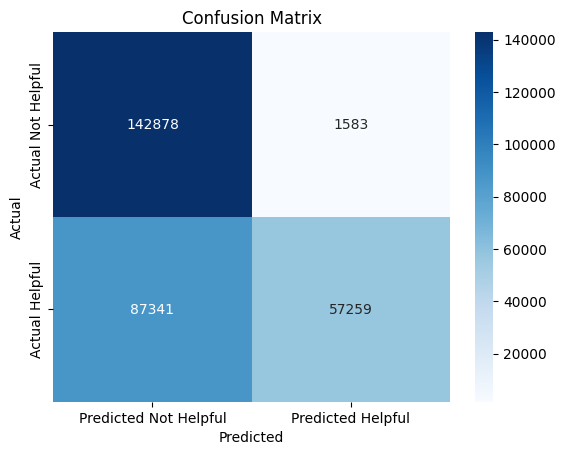

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(classification['helpful_bool'], classification['pred_helpful_bool'])

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Not Helpful', 'Predicted Helpful'], yticklabels=['Actual Not Helpful', 'Actual Helpful'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Generate and print the classification report
report = classification_report(classification['helpful_bool'], classification['pred_helpful_bool'])
print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.99      0.76    144461
           1       0.97      0.40      0.56    144600

    accuracy                           0.69    289061
   macro avg       0.80      0.69      0.66    289061
weighted avg       0.80      0.69      0.66    289061

